In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [3]:
train.loc[0, 'full_text']

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

In [4]:
train['cohesion'].describe()

count    3911.000000
mean        3.127077
std         0.662542
min         1.000000
25%         2.500000
50%         3.000000
75%         3.500000
max         5.000000
Name: cohesion, dtype: float64

For this dataset, we'll try to predict scores ranked 1 - 5 across 6 categories - Cohesion, Syntax, Vocabulary, Phraseology, Grammar and Conventions. For a baseline, a simple neural network will be built which will perform the task of regression since the values we're trying to predict are continuous numerical values. 

In [5]:
test = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')
len(test)

3

In [6]:
sample_sub = pd.read_csv('../input/feedback-prize-english-language-learning/sample_submission.csv')
sample_sub.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


In [7]:
len(sample_sub)

3

All clear. Let's work on trying to process the text data

In [8]:
inputs = train['full_text'].values.tolist()

targets = train[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].values.tolist()

In [9]:
inputs[0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

In [10]:
targets[0]

[3.5, 3.5, 3.0, 3.0, 4.0, 3.0]

### Preprocessing the text inputs

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 20000
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(inputs)

In [12]:
sequences = tokenizer.texts_to_sequences(inputs)

In [13]:
print(len(tokenizer.word_index))

22169


In [14]:
len_cap = np.array([len(text.split()) for text in inputs])
print(len_cap.mean(), len_cap.std(), len_cap.max(), len_cap.min())
max_seq_len = int(np.percentile(len_cap,99.9))
print(max_seq_len)

430.4929685502429 191.84391798135536 1260 14
1223


Text(0.5, 1.0, 'Word Frequency Distribution in Essays')

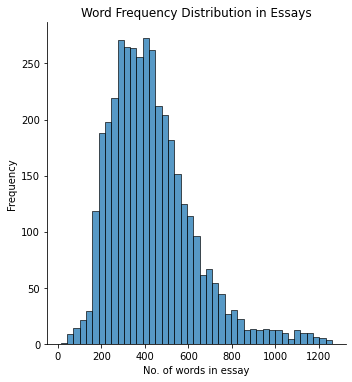

In [15]:
# let's see the distribution of word counts

train_texts_size = list(map(lambda x: len(x.split()), inputs))
sns.displot(train_texts_size)
plt.xlabel('No. of words in essay')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in Essays')

512 words might be a good place to clip the essays

In [16]:
maxlen = 512

inputs = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

In [17]:
inputs[0].shape, targets[0]

((512,), [3.5, 3.5, 3.0, 3.0, 4.0, 3.0])

In [18]:
inputs = np.array(inputs)
targets = np.array(targets)

## ML Models

In [19]:
model = models.Sequential(name='baseline')
model.add(layers.Embedding(input_dim=num_words, output_dim=100, input_length=512))
model.add(layers.LSTM(64, dropout=0.2, return_sequences=True))
model.add(layers.LSTM(64, dropout=0.2, return_sequences=False))
model.add(layers.Dense(6))

2022-09-01 11:21:07.656018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 11:21:07.790077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 11:21:07.791285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 11:21:07.793028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 100)          2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 512, 64)           42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 2,075,654
Trainable params: 2,075,654
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='mse', optimizer='adam', metrics='acc')

In [22]:
history = model.fit(x=inputs, y=targets, epochs=20)

Epoch 1/20


2022-09-01 11:21:11.171270: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-01 11:21:14.433470: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


123/123 [==============================] - 10s 41ms/step - loss: 1.2352 - acc: 0.2242
Epoch 2/20
123/123 [==============================] - 5s 39ms/step - loss: 0.4319 - acc: 0.2296
Epoch 3/20
123/123 [==============================] - 5s 40ms/step - loss: 0.4344 - acc: 0.2219
Epoch 4/20
123/123 [==============================] - 5s 39ms/step - loss: 0.4325 - acc: 0.2161
Epoch 5/20
123/123 [==============================] - 5s 39ms/step - loss: 0.4279 - acc: 0.2340
Epoch 6/20
123/123 [==============================] - 5s 40ms/step - loss: 0.4147 - acc: 0.2250
Epoch 7/20
123/123 [==============================] - 5s 40ms/step - loss: 0.3942 - acc: 0.2309
Epoch 8/20
123/123 [==============================] - 5s 40ms/step - loss: 0.3810 - acc: 0.2291
Epoch 9/20
123/123 [==============================] - 5s 39ms/step - loss: 0.3685 - acc: 0.2322
Epoch 10/20
123/123 [==============================] - 5s 39ms/step - loss: 0.3588 - acc: 0.2278
Epoch 11/20
123/123 [============================

### Evaluate the Baseline Model

In [23]:
test = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [24]:
inputs = test['full_text'].values.tolist()
inputs = tokenizer.texts_to_sequences(inputs)
inputs = pad_sequences(inputs, maxlen=512, padding='post', truncating='post')

In [25]:
inputs[0]

array([   41,     5,    75,   108,   128,   224,    37,     5,   116,
          30,     9,    79,    69,     1,    14,    36,    18,     1,
          48,     4,     3,   111,     1,  5456,     2,   116,     4,
          65,     1,    38,   197,     7,    46,     4,   192,    20,
         991,    25,   478,   187,    46,     9,    52,  5648,   107,
          67,   152,   801,    88,   112,   445,   208,   224,    17,
          46,     9,   903,     3,    27,   432,   248,   233,     3,
         216,    25,     2,    18,    27,   261,    41,     5,    75,
         736,     8,    64,   187,     7,    46,     8,   167,    21,
          36,    17,     8,   193,     1,    50,     2,    61,    75,
         304,    92,   106,     4,   432,    14,   360,     1,   180,
           2,   167,    12,   224,    17,     4,   162,    20,    64,
          42,    88,     4,    29,    74,     1,     5,   139,   366,
          41,     4,   167,    64,  6021,    17,     4,    20,    57,
          30,    47,

In [26]:
predictions = model.predict(inputs)
predictions = predictions.tolist()
predictions[0]

[3.3876137733459473,
 3.260181427001953,
 3.4959914684295654,
 3.4186742305755615,
 3.206434726715088,
 3.338707208633423]

In [27]:
submission = pd.DataFrame(predictions, columns=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'])
submission = pd.concat([test['text_id'], submission], axis=1)
submission

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.387614,3.260181,3.495991,3.418674,3.206435,3.338707
1,000BAD50D026,3.513735,3.428759,3.606724,3.591037,3.506624,3.539623
2,00367BB2546B,3.417633,3.334422,3.517328,3.484051,3.399555,3.444702


In [28]:
submission.to_csv('submission.csv', index=False)